**Step 1. 데이터의 전처리**<br>
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.<br>
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [373]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [374]:
data['UserId'].nunique(), data['ItemId'].nunique()

(201, 427)

In [375]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [376]:
datatemp = data.copy()

datatemp['Time_diff'] = datatemp['Time'].diff().fillna(0)
datatemp['Change_User'] = datatemp['UserId'].diff().fillna(0)

user_id = 1  ##
def make_user(x, max_diff):
    global user_id
    if x['Time_diff']>3000 or x['Change_User']==1:
        user_id += 1
    return user_id

datatemp['UserId'] = datatemp.apply(make_user, max_diff=200, axis=1) ##
user_length = datatemp.groupby('UserId').size()

In [377]:
datatemp ##

,UserId,ItemId,Rating,Time,Time_diff,Change_User
31,1,3186,4,978300019,0.0,0.0
22,1,1270,5,978300055,36.0,0.0
27,1,1721,4,978300055,0.0,0.0
37,1,1022,5,978300055,0.0,0.0
24,1,2340,3,978300103,48.0,0.0
...,...,...,...,...,...,...
1000019,24558,2917,4,997454429,31.0,0.0
999988,24558,1921,4,997454464,35.0,0.0
1000172,24558,1784,3,997454464,0.0,0.0
1000167,24558,161,3,997454486,22.0,0.0


In [378]:
def convert_datetime(unixtime): ##
    """Convert unixtime to datetime"""
    date = dt.datetime.fromtimestamp(unixtime).strftime('%Y-%m-%d %H:%M:%S')
    date = dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
    return date

https://potensj.tistory.com/72

In [379]:
data['Time'] = data.Time.apply(convert_datetime) ##

In [380]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [381]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [382]:
user_length.min(), user_length.max()

(20, 2314)

In [383]:
user_length.quantile(0.999)

1343.181000000005

In [384]:
long_user = user_length[user_length==200].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
406366,2438,908,3,2000-11-14 17:28:41
406379,2438,2294,3,2000-11-14 17:28:41
406412,2438,3812,5,2000-11-14 17:28:41
406418,2438,3835,2,2000-11-14 17:28:41
406427,2438,1186,4,2000-11-14 17:28:41
...,...,...,...,...
406356,2438,3948,4,2001-01-18 04:27:56
406461,2438,2502,4,2001-02-04 04:46:41
406372,2438,1466,4,2001-02-04 21:43:09
406413,2438,1131,5,2001-04-13 02:08:11


In [385]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

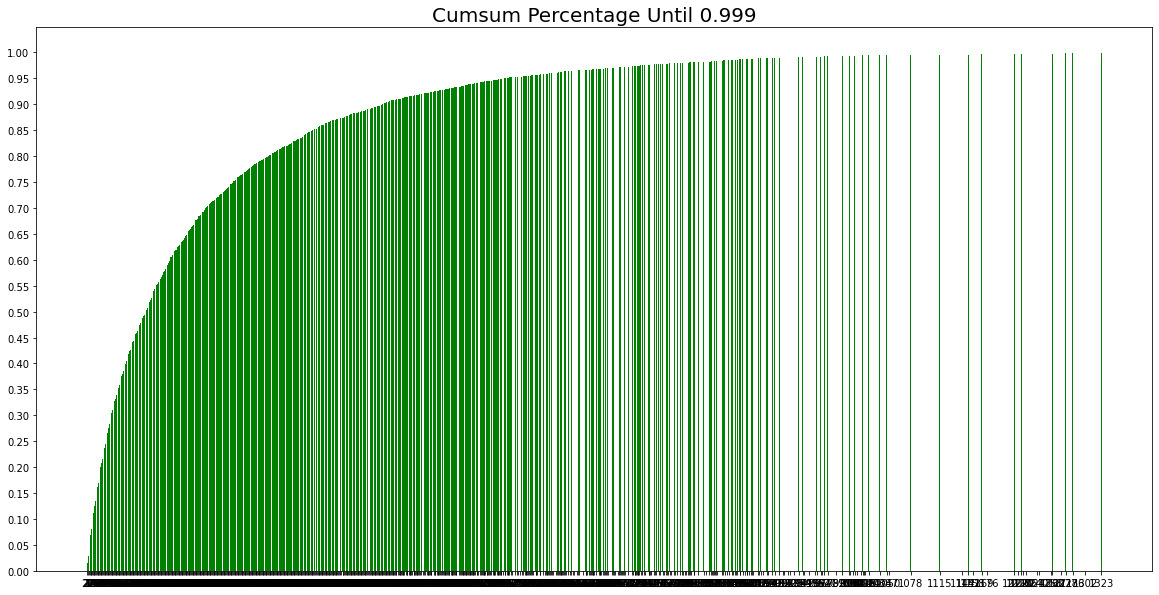

In [386]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='green')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [387]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [388]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [389]:
month_ago = latest - dt.timedelta(120)     # 최종 날짜로부터 120일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
5200,36,2269,5,2002-12-22 08:05:50
5256,36,1701,4,2002-12-22 08:05:50
5184,36,2694,3,2002-12-22 08:08:14
5364,36,3786,4,2002-12-22 08:08:41
5262,36,2369,4,2002-12-22 08:09:24
...,...,...,...,...
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37
984733,5950,1262,4,2003-02-27 18:17:38


In [390]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [391]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
5364,36,3786,4,2002-12-22 08:08:41
5262,36,2369,4,2002-12-22 08:09:24
5280,36,3174,4,2002-12-22 08:11:25
5222,36,296,5,2002-12-22 08:16:59
5104,36,247,4,2002-12-22 08:17:48
...,...,...,...,...
984731,5950,3948,4,2003-02-27 18:13:57
984682,5950,3578,4,2003-02-27 18:14:30
984475,5950,3793,3,2003-02-27 18:15:10
984660,5950,3555,2,2003-02-27 18:15:37


In [392]:
test_path = data_path / 'ratings.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(956703932, 1046454590)

In [393]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max()
    user_in_train = user_last_time[user_last_time < final_time - dt.timedelta(n_days)].index
    user_in_test = user_last_time[user_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(user_in_train)]
    after_date = data[data['UserId'].isin(user_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [394]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [395]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [396]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 2992
	 Users: 193
	 Items: 427
	 First Time : 2002-10-31 19:58:49
	 Last Time : 2003-02-25 21:07:49

* valid Set Stats Info
	 Events: 144
	 Users: 6
	 Items: 130
	 First Time : 2002-11-05 22:35:05
	 Last Time : 2003-02-27 14:22:07

* test Set Stats Info
	 Events: 78
	 Users: 2
	 Items: 78
	 First Time : 2002-11-01 19:21:01
	 Last Time : 2003-02-28 17:45:20



In [397]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [398]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

**Step 2. 미니 배치의 구성**<br>
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.<br>
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [399]:
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to userId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each user IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [400]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
5364,36,3786,4,2002-12-22 08:08:41,0
5262,36,2369,4,2002-12-22 08:09:24,1
5280,36,3174,4,2002-12-22 08:11:25,2
5222,36,296,5,2002-12-22 08:16:59,3
5104,36,247,4,2002-12-22 08:17:48,4
5062,36,1266,5,2002-12-22 08:18:29,5
5076,36,595,4,2002-12-22 08:18:29,6
5180,36,3639,4,2002-12-22 08:18:45,7
8704,59,2997,4,2003-01-07 18:02:48,8
8781,59,2369,4,2003-01-07 18:04:24,1


In [401]:
tr_dataset.click_offsets

array([   0,    8,   70,  139,  148,  186,  197,  251,  267,  272,  277,
        280,  283,  297,  313,  315,  447,  453,  506,  518,  524,  527,
        548,  550,  556,  561,  563,  567,  605,  642,  644,  648,  653,
        655,  671,  683,  685,  693,  697,  747,  756,  771,  794,  799,
        809,  811, 1038, 1044, 1064, 1069, 1072, 1100, 1106, 1109, 1112,
       1115, 1119, 1139, 1143, 1157, 1160, 1171, 1181, 1185, 1189, 1191,
       1198, 1200, 1210, 1217, 1223, 1225, 1281, 1305, 1309, 1317, 1336,
       1344, 1370, 1378, 1381, 1422, 1432, 1438, 1442, 1448, 1468, 1486,
       1494, 1508, 1525, 1527, 1531, 1542, 1579, 1585, 1591, 1601, 1604,
       1609, 1621, 1623, 1636, 1720, 1738, 1740, 1811, 1814, 1851, 1855,
       1888, 1890, 1892, 1894, 1899, 1903, 1916, 1923, 1928, 1934, 1938,
       1940, 1953, 2028, 2042, 2057, 2059, 2075, 2078, 2088, 2092, 2097,
       2104, 2121, 2123, 2136, 2146, 2149, 2151, 2154, 2158, 2168, 2174,
       2258, 2265, 2268, 2277, 2287, 2300, 2316, 23

In [402]:
tr_dataset.user_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [403]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the user to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where User Start
        end : Index Where User End
        mask : indicator for the user to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among User
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 user이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]  # user이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 user이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 user이 마지막 user index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 user의 위치를 기록해둡니다.
        return start, end, mask, last_user, finished

In [404]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
5364,36,3786,4,2002-12-22 08:08:41,0
5262,36,2369,4,2002-12-22 08:09:24,1
5280,36,3174,4,2002-12-22 08:11:25,2
5222,36,296,5,2002-12-22 08:16:59,3
5104,36,247,4,2002-12-22 08:17:48,4
5062,36,1266,5,2002-12-22 08:18:29,5
5076,36,595,4,2002-12-22 08:18:29,6
5180,36,3639,4,2002-12-22 08:18:45,7
8704,59,2997,4,2003-01-07 18:02:48,8
8781,59,2369,4,2003-01-07 18:04:24,1


In [405]:
iter_ex = iter(tr_data_loader)

In [406]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  8 68 92]
Label Item Idx are :       [  1   1  69 100]
Previous Masked Input Idx are []


**Step 3. 모델 구성**<br>
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [407]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [408]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [409]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [542]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_user = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=6, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [543]:
model = create_model(args)

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(6, 1, 427)]             0         
_________________________________________________________________
GRU (GRU)                    [(6, 50), (6, 50)]        71850     
_________________________________________________________________
dropout_37 (Dropout)         (6, 50)                   0         
_________________________________________________________________
dense_37 (Dense)             (6, 427)                  21777     
Total params: 93,627
Trainable params: 93,627
Non-trainable params: 0
_________________________________________________________________


**Step 4. 모델 학습**<br>
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [544]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 user은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [545]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/466 [00:00<?, ?it/s, accuracy=0, train_loss=5.87]    

	 - Recall@20 epoch 1: 0.229167
	 - MRR@20    epoch 1: 0.026672



Train:   0%|          | 0/466 [00:00<?, ?it/s, accuracy=0, train_loss=5.83]    

	 - Recall@20 epoch 2: 0.166667
	 - MRR@20    epoch 2: 0.020486



Evaluation:  35%|███▍      | 8/23 [00:00<00:00, 15.67it/s]

	 - Recall@20 epoch 3: 0.166667
	 - MRR@20    epoch 3: 0.028801



**Step 5. 모델 테스트**<br>
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

**Recall@20 : 0.166667<br>
MRR@20 : 0.028801**

**Step 6. 회고<br>**
*최근에 치른 익스 노드중 가장 까다로웠다고 생각합니다. 우선 노드에서는 년,월,일과 같이 시간이 구체적으로 주어졌는데<br>
실습 과제에서는 정수형으로만 값이 주어져서 바꾸는 작업을 필요로 했습니다.<br><br> 
그리고 latest - dt.timedelta를 빼줄때 오류가 발생해서 통일해주는 작업을 해주었습니다.<br><br>
또 out of bounds 에러가 왜 나는지 몰랐는데 batch_size를 알맞게 조절해주니 해결되는 것을 알았습니다.<br><br>
마지막으로 세션을 나눠주는 작업을 일일이 해야하는지 고민을 많이 했는데 주변 동료의 도움을 받아 pandas에 diff 함수를 이용하면 세션을<br>
쉽게 나눌 수 있다는 점을 알아서 사용했습니다.*